# Integrated Gradients

In [ ]:
!pip install alibi

     |████████████████████████████████| 225kB 2.7MB/s 
     |████████████████████████████████| 327kB 8.4MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 28.0MB 149kB/s 
     |████████████████████████████████| 204kB 39.2MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456480 sha256=cec2527b9406cad8e766fc9bb263340b7e9550af16e2fca8d3b43af91d1680a5
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052144 sha256=e6ccbc91fcdb3cd950640f7f0336fd0a7eb1b4d2472c533f565a6504f58bd416
  Stored in directory: /root/.cache/pip/wheels/2a/2b/0a/d6fb6235c56d014d224bca760d15d7cbdd820813085ffcd35d
Successfully built shap spacy-lookups-data


In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import IntegratedGradients
import matplotlib.pyplot as plt
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # True

TF version:  2.3.0
Eager execution enabled:  True


In [ ]:
train, test = tf.keras.datasets.fashion_mnist.load_data()
X_train, y_train = train
X_test, y_test = test
test_labels = y_test.copy()
train_labels = y_train.copy()

X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


In [ ]:
load_fashion_mnist_model = False
save_model = True

In [ ]:
filepath = './model_mnist/'  # change to directory where model is saved
if load_fashion_mnist_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]), dtype=tf.float64)
    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)

    x = Conv2D(32, 2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(10, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # train model
    model.fit(X_train,
              y_train,
              epochs=6,
              batch_size=256,
              verbose=1,
              validation_data=(X_test, y_test)
              )
    if save_model:
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        model.save(os.path.join(filepath, 'model.h5'))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/6
235/235 [==============================] - 64s 271ms/step - loss: 0.7264 - accuracy: 0.7288 - val_loss: 0.4772 - val_accuracy: 0.8197
Epoch 2/6
235/235 [==============================] - 64s 270ms/step - loss: 0.4642 - accuracy: 0.8311 - val_loss: 0.3936 - val_accuracy: 0.8582
Epoch 3/6
235/235 [==============================] - 64s 273ms/step - loss: 0.4127 - accuracy: 0.8504 - val_loss: 0.3549 - val_accuracy: 0.8677
Epoch 4/6
235/235 [==============================] - 63s 268ms/step - loss: 

In [ ]:
# Initialize IntegratedGradients instance
n_steps = 50
method = "gausslegendre"
ig  = IntegratedGradients(model,
                          n_steps=n_steps,
                          method=method)

In [ ]:
# Calculate attributions for the first 10 images in the test set
nb_samples = 10
X_test_sample = X_test[:nb_samples]
predictions = model(X_test_sample).numpy().argmax(axis=1)
explanation = ig.explain(X_test_sample,
                         baselines=None,
                         target=predictions)

In [ ]:
# Metadata from the explanation object
explanation.meta

{'explanations': ['local'],
 'name': 'IntegratedGradients',
 'params': {'internal_batch_size': 100,
  'layer': 0,
  'method': 'gausslegendre',
  'n_steps': 50},
 'type': ['whitebox']}

In [ ]:
# Data fields from the explanation object
explanation.data.keys()

dict_keys(['attributions', 'X', 'baselines', 'predictions', 'deltas', 'target'])

In [ ]:
# Get attributions values from the explanation object
attrs = explanation.attributions

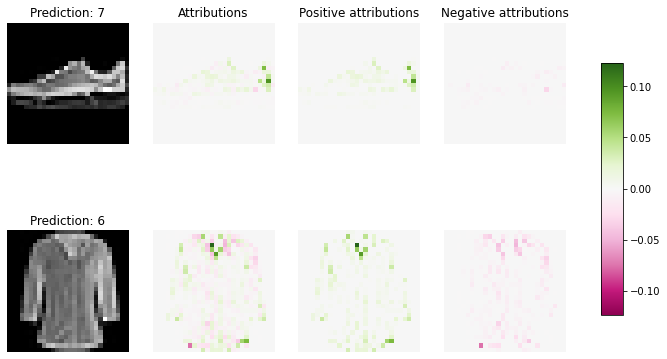

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10, 7))
image_ids = [9, 4]
cmap_bound = np.abs(attrs[[9, 4]]).max()

for row, image_id in enumerate(image_ids):
    # original images
    ax[row, 0].imshow(X_test[image_id].squeeze(), cmap='gray')
    ax[row, 0].set_title(f'Prediction: {predictions[image_id]}')

    # attributions
    attr = attrs[image_id]
    im = ax[row, 1].imshow(attr.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')

    # positive attributions
    attr_pos = attr.clip(0, 1)
    im_pos = ax[row, 2].imshow(attr_pos.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')

    # negative attributions
    attr_neg = attr.clip(-1, 0)
    im_neg = ax[row, 3].imshow(attr_neg.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')

ax[0, 1].set_title('Attributions');
ax[0, 2].set_title('Positive attributions');
ax[0, 3].set_title('Negative attributions');

for ax in fig.axes:
    ax.axis('off')

fig.colorbar(im, cax=fig.add_axes([0.95, 0.25, 0.03, 0.5]));

Integrated Gradients is a XAI technique primarily used on Image and Text Dataset. It shows us the specific attributions of the image text that are positive attributions and negative attributions. 

1. Positive attributions: Positive attributions and attributions that contribute or influence the model to make the right decision. For example, in Fashion MNIST dataset, if we take the image of a shoe, then the positive attributions are the pixels of the image which make a positive influence to the model predicting that it is a shoe. It can be various specific pixels showing some unique features of shoe such as laces, sole, etc. 

2. Negative attributions: Negative attributions and attributions that contribute or influence the model to make the wrong decision. For example, in Fashion MNIST dataset, if we take the image of a shoe, then the negative attributions are the pixels of the image which go against the model predicting it as a shoe. For example, the sole of a shoe might be mixed as a flip flop, etc. 

We have taken two examples in our colab. Explaining these now:

1st Example: It is an image of a shoe. The attributions section show a melange of positive and negative attributions together. As we can see from the bar on the right side, green signifies a positive attributions and purple signifies a negative attributions. The shoe is unique compared to other clothing items, and hence, it has a lot more positive attributes than negatives. The lining, collar and back part of the shoe are the main pixels that influence the decision of the model. On the other hand, the negative attributions are negligible for this particular instance. 

2nd Example: It is an image of a shirt where there an equal number of positive and negative attributions. The pixels around the collar and the sleeves are the biggest positive attributions. However, the middle portion of the shirt can be mistaken to be a part of a pair of jeans or trousers. Therefore, due to this ambiguity, they are the negative attributions for the prediction. All in all, we can say that when the positive attributions outweigh the negative attributions, the model makes the correct prediction. 

This method has various applications and is primarily used to check where the model is making mistakes so that ammendments can be made in order to improve the accuracy of the model.